In [1]:
import numpy as np
from numpy import ma
import xarray as xr
from glob import glob
from datetime import datetime, timedelta
from scipy import ndimage as ndi
from dateutil.parser import parse as parse_date
import argparse
from python_toolbox import abi_tools, dataset_tools, opt_flow
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

In [4]:
# Getting files (on jasmin)

base_path = '/gws/nopw/j04/eo_shared_data_vol2/scratch/satellite/GOES16/RadC/'

start_date = datetime(2018,6,19,17)
end_date = datetime(2018,6,19,19)
doy_start = (start_date - datetime(start_date.year, 1, 1)).days + 1
doy_end = (end_date - datetime(end_date.year, 1, 1)).days + 1

file_names = []
for year in range(start_date.year, end_date.year+1):
    year_str = str(year).zfill(4)
    if start_date.year == end_date.year:
        for doy in range(doy_start, doy_end+1):
            doy_str = str(doy).zfill(3)
            goes_path = base_path +year_str+'/'+doy_str+'/'
            file_names.extend(glob(goes_path+'*/*C08_*.nc'))
    elif year == start_date.year:
        for doy in range(doy_start, (datetime(year+1,1,1)-datetime(year,1,1)).days+1):
            doy_str = str(doy).zfill(3)
            goes_path = base_path +year_str+'/'+doy_str+'/'
            file_names.extend(glob(goes_path+'*/*C08_*.nc'))
    elif year == end_date.year:
        for doy in range(1, doy_end+1):
            doy_str = str(doy).zfill(3)
            goes_path = base_path +year_str+'/'+doy_str+'/'
            file_names.extend(glob(goes_path+'*/*C08_*.nc'))
    else:
        for doy in range(1, (datetime(year+1,1,1)-datetime(year,1,1)).days+1):
            doy_str = str(doy).zfill(3)
            goes_path = base_path +year_str+'/'+doy_str+'/'
            file_names.extend(glob(goes_path+'*/*C08_*.nc'))

# Get all filenames
goes_files = [abi_tools.get_goes_abi_files(f) for f in file_names]
# Filter for start and end date
goes_files = [f for f in goes_files if f[0] >= start_date and f[0] <= end_date and len(f) == 17]

len(goes_files)

23

In [5]:
# Get brightness temperature for channel 8,10,13 and 15
# Upper level water vapour (6.2um)
C8_data = abi_tools.get_abi_ds_from_files([f[8] for f in goes_files])[:,600:900,1300:1600]
# Lower level water vapour (7.3um)
C10_data = abi_tools.get_abi_ds_from_files([f[10] for f in goes_files])[:,600:900,1300:1600]
# Clean IR LW window channel(10.8um)
C13_data = abi_tools.get_abi_ds_from_files([f[13] for f in goes_files])[:,600:900,1300:1600]
# Dirty IR LW window channel(12.0um)
C15_data = abi_tools.get_abi_ds_from_files([f[15] for f in goes_files])[:,600:900,1300:1600]

dataset_tools.match_coords([C13_data,C10_data,C8_data,C15_data])


In [6]:
# water vapour and split window differences
wvd = C8_data - C10_data
swd = C13_data - C15_data


Text(0.5,1,'Split window difference')

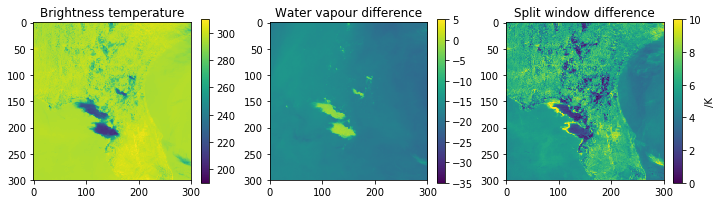

In [15]:
fig, ax = plt.subplots(1,3,figsize=(12,3))
bt = ax[0].imshow(C13_data[12], vmin=190,vmax=310)
plt.colorbar(bt, ax=ax[0])
ax[0].set_title('Brightness temperature')

wv = ax[1].imshow(wvd[12], vmin=-35,vmax=5)
plt.colorbar(wv, ax=ax[1])
ax[1].set_title('Water vapour difference')

sw = ax[2].imshow(swd[12], vmin=0,vmax=10)
plt.colorbar(sw, label='/K', ax=ax[2])
ax[2].set_title('Split window difference')


Note that the split window temperatures are low in the middle of deep clouds, but high at the edges. I am using this to distinguish between the core and anvil parts of DCCs

In [16]:
field_flow = opt_flow.get_flow_func(C13_data, replace_missing=True)

Text(0.5,1,'Y flow vector')

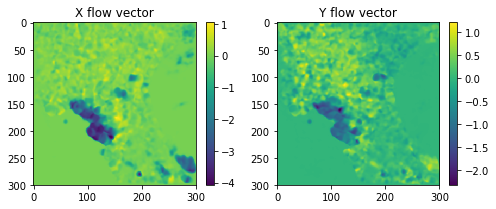

In [19]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
x_vec = ax[0].imshow(field_flow(1)[0][12])
plt.colorbar(x_vec, ax=ax[0])
ax[0].set_title('X flow vector')

y_vec = ax[1].imshow(field_flow(1)[1][12])
plt.colorbar(y_vec, ax=ax[1])
ax[1].set_title('Y flow vector')



## Semi-lagrangian BT cooling

In [20]:
# this gets a 3*arr.shape array of the field interpolated by one frame forwards and backwards
bt_stack = opt_flow.get_flow_stack(C13_data, field_flow).data.rechunk((3,1,300,300))

In [21]:
# delta t, and also the spatial second derivative to find peaks in the brightness temperature
bt_dt = np.gradient(bt_stack, axis=0)[1]
bt_grad = np.gradient(np.gradient(bt_stack[1], axis=1), axis=1) + np.gradient(np.gradient(bt_stack[1], axis=2), axis=2)

Text(0.5,1,'grad BT smoothed')

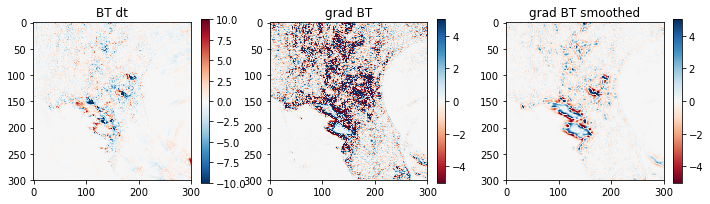

In [60]:
fig, ax = plt.subplots(1,3,figsize=(12,3))
btdt = ax[0].imshow(bt_dt[12],vmin=-10,vmax=10,cmap='RdBu_r')
plt.colorbar(btdt, ax=ax[0])
ax[0].set_title('BT dt')

gradbt = ax[1].imshow(bt_grad[12],vmin=-5,vmax=5,cmap='RdBu')
plt.colorbar(gradbt, ax=ax[1])
ax[1].set_title('grad BT')

gradbts = ax[2].imshow(ndi.gaussian_filter(bt_grad[12],(1.5,1.5)),vmin=-5,vmax=5,cmap='RdBu')
plt.colorbar(gradbts, ax=ax[2])
ax[2].set_title('grad BT smoothed')


By multiplying these fields we can get a metric for how much a peak in the BT field (positive grad) is growing (negative BTdt)

In [25]:
bt_growth = np.minimum(np.maximum(np.maximum(-bt_dt,0)*ndi.gaussian_filter(bt_grad,(0,1.5,1.5))/5,0),10)
# gaussian filter applied to grad bt to reduce noise

In [26]:
#dilate the field in a semi-lagrangian way
bt_growth_dilate = opt_flow.flow_convolve(
                       opt_flow.get_flow_stack(
                           xr.DataArray(bt_growth, dims=('t','y','x')), 
                           field_flow, method='linear').to_masked_array(), 
                       function=np.nanmax)

Text(0.5,1,'BT growth metric')

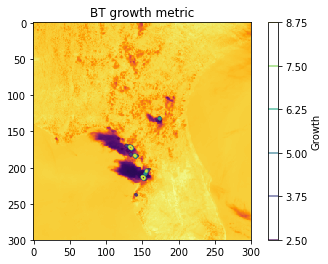

In [59]:
plt.imshow(C13_data[12],cmap='inferno',vmax=310,vmin=190)
plt.contour(bt_growth_dilate[1],np.arange(2.5,11.25,1.25), alpha=0.75)
# plt.gca().invert_yaxis()
plt.colorbar(label='Growth')
plt.title('BT growth metric')

I've found that 2.5 is a good value for this, it's approximately equal to a peak cooling of 0.5K/minute

## Semi-lagrangian watershedding

In [31]:
upper_thresh = -5
lower_thresh = -15
markers = wvd>upper_thresh
markers = np.logical_and(markers, bt_growth_dilate>2.5).compute().to_masked_array()
mask = (wvd<lower_thresh).compute().to_masked_array()
for i in range(np.minimum(3, (mask.shape[0]-1)//2)):
    # Semi-lagrangian erosion of the mask by up to three steps
    mask = opt_flow.flow_convolve(opt_flow.get_flow_stack(xr.DataArray(mask, dims=('t','y','x')), 
                                  field_flow, method='nearest').to_masked_array(), 
                                  function=np.nanmin)

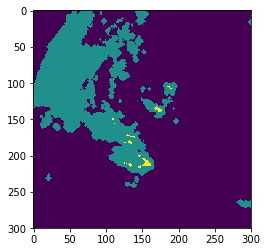

In [32]:
plt.imshow((markers.astype(int)-mask.astype(int))[12])

Markers in yellow. Mask in dark blue. Unfilled regions are in teal

In [34]:
# Sobel edge detection for watershedding. Combine WVD, SWD and growth to find regions
inner_edges = opt_flow.flow_sobel(opt_flow.get_flow_stack(
                                      xr.DataArray(
                                          np.minimum(np.maximum(
                                              opt_flow.flow_convolve(
                                                  opt_flow.get_flow_stack((wvd-swd+bt_growth_dilate-5).compute(), 
                                                                          field_flow, method='linear').to_masked_array(), 
                                                  function=np.nanmax)
                                              , lower_thresh), upper_thresh), 
                                          dims=('t','y','x')),
                                      field_flow).compute().to_masked_array(), 
                                  direction='uphill', magnitude=True)


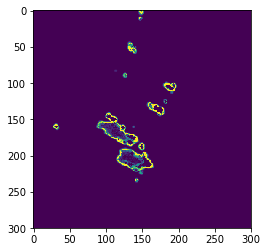

In [35]:
plt.imshow(inner_edges[12],vmin=0,vmax=50)

In [50]:
# Watershed
features = opt_flow.flow_network_watershed(inner_edges, markers, field_flow, mask=mask, 
                                           structure=ndi.morphology.generate_binary_structure(3,2), 
                                           debug_mode=True)


Calculating field stack
Calculating indices stack
Calculating nearest neighbours
Finding network convergence locations
Iteration: 1
Pixels converged 294576
Iteration: 2
Pixels converged 473932
Iteration: 3
Pixels converged 702112
Iteration: 4
Pixels converged 951372
Iteration: 5
Pixels converged 1226464
Iteration: 6
Pixels converged 1570645
Iteration: 7
Pixels converged 1898942
Iteration: 8
Pixels converged 2045133
Iteration: 9
Pixels converged 2070000
All pixels converged
Filling basins
Joining labels
max_markers: True
Iteration: 1
Remaining labels: 813
Max label: 7411
Labels: [ 0  1  2  3  5  8 10 31 34 85]
New: [ 823 2597    2    5    5    8 3220   31   34   85]
Iteration: 2
Remaining labels: 79
Max label: 7150
Labels: [  0   1   3 300 313 332 350 517 529 543]
New: [   5 3757    3  300  313  332  350  517  529  543]
Iteration: 3
Remaining labels: 13
Max label: 5977
Labels: [   0    1 3268 3597 3924 3934 4218 4250 4344 4348]
New: [   3 3396 3268 3597 3924 4250 4218 4344 5176 4348]
It

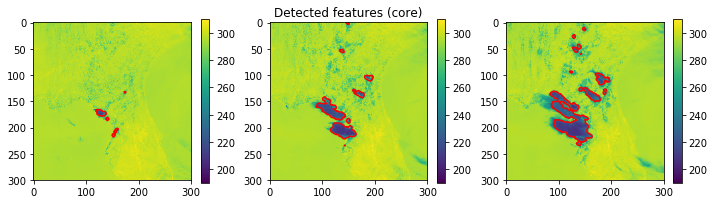

In [51]:
fig, ax = plt.subplots(1,3,figsize=(12,3))

m0 = ax[0].imshow(C13_data[0],vmin=190,vmax=310)
plt.colorbar(m0, ax=ax[0])
ax[0].contour(features[0],[0.5],colors=['red'])

m1 = ax[1].imshow(C13_data[12],vmin=190,vmax=310)
plt.colorbar(m1, ax=ax[1])
ax[1].contour(features[12],[0.5],colors=['red'])
ax[1].set_title('Detected features (core)')

m2 = ax[2].imshow(C13_data[-1],vmin=190,vmax=310)
plt.colorbar(m2, ax=ax[2])
ax[2].contour(features[-1],[0.5],colors=['red'])


Repeat for outer regions

In [45]:

outer_edges = opt_flow.flow_sobel(opt_flow.get_flow_stack(
                                      xr.DataArray(
                                          np.minimum(np.maximum(
                                              opt_flow.flow_convolve(
                                                  opt_flow.get_flow_stack((wvd+swd+bt_growth_dilate).compute(), 
                                                                          field_flow, method='linear').to_masked_array(), 
                                                  function=np.nanmax)
                                              , lower_thresh), upper_thresh), 
                                          dims=('t','y','x')),
                                      field_flow).compute().to_masked_array(), 
                                  direction='uphill', magnitude=True)


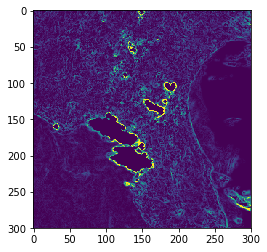

In [54]:
plt.imshow(outer_edges[12],vmin=0,vmax=50)

In [56]:
# Watershed
outer = opt_flow.flow_network_watershed(outer_edges, features, field_flow, mask=mask, 
                                           structure=ndi.morphology.generate_binary_structure(3,2), 
                                           debug_mode=True)


Calculating field stack
Calculating indices stack
Calculating nearest neighbours
Finding network convergence locations
Iteration: 1
Pixels converged 826528
Iteration: 2
Pixels converged 1512744
Iteration: 3
Pixels converged 1906143
Iteration: 4
Pixels converged 1985654
Iteration: 5
Pixels converged 2033703
Iteration: 6
Pixels converged 2062699
Iteration: 7
Pixels converged 2070000
All pixels converged
Filling basins
Joining labels
max_markers: 1
Iteration: 1
Remaining labels: 5138
Max label: 25738
Labels: [ 0  1  2  4 12 13 17 18 19 20]
New: [12669 12884     2     4    12    13    17    18    19    20]
Iteration: 2
Remaining labels: 770
Max label: 25601
Labels: [  0   1  18  80  81 118 128 163 196 216]
New: [14914 11205    18    80    81   118   128   163   196   216]
Iteration: 3
Remaining labels: 112
Max label: 22127
Labels: [   0    1  678  768 1011 1023 1036 1038 1109 1337]
New: [18434 16745   768 10088  1011  1109  1109  1038 11001  1337]
Iteration: 4
Remaining labels: 25
Max labe

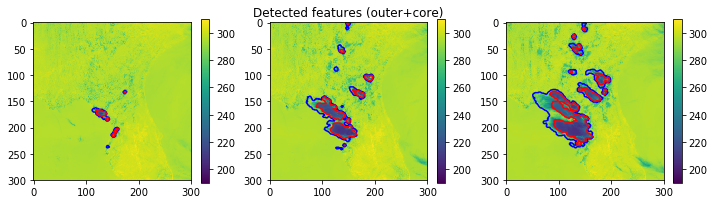

In [57]:
fig, ax = plt.subplots(1,3,figsize=(12,3))

m0 = ax[0].imshow(C13_data[0],vmin=190,vmax=310)
plt.colorbar(m0, ax=ax[0])
ax[0].contour(outer[0],[0.5],colors=['blue'])
ax[0].contour(features[0],[0.5],colors=['red'])

m1 = ax[1].imshow(C13_data[12],vmin=190,vmax=310)
plt.colorbar(m1, ax=ax[1])
ax[1].contour(outer[12],[0.5],colors=['blue'])
ax[1].contour(features[12],[0.5],colors=['red'])
ax[1].set_title('Detected features (outer+core)')

m2 = ax[2].imshow(C13_data[-1],vmin=190,vmax=310)
plt.colorbar(m2, ax=ax[2])
ax[2].contour(outer[-1],[0.5],colors=['blue'])
ax[2].contour(features[-1],[0.5],colors=['red'])


The 'outer' region seems to pick up the extent of the anvil outflow fairly well

Picking out the mean brightness temperature of each region at each step and plotting one. Looks reasonable

In [82]:
inner_labels = ndi.label(features)[0]
bt_labels = [[np.nanmean(C13_data[j].data.ravel()[(inner_labels[j]==i).ravel()]) 
              for j in range(C13_data.shape[0]) if np.any(inner_labels[j]==i)] 
             for i in np.arange(1,inner_labels.max()+1)]

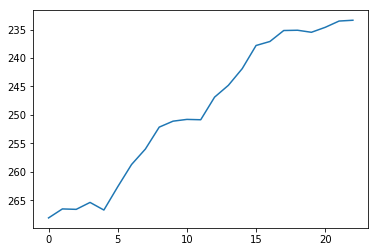

In [84]:
plt.plot(bt_labels[0])
plt.gca().invert_yaxis()